In [7]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from stl import mesh
from mpl_toolkits import mplot3d
import os
import scipy.constants as const

#import ParticlePlottingFunctions
import ParticlePlottingFunctions as ppf
%load_ext autoreload 
%autoreload 2

# %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
file1 = "500UCN_Fill_minus1_moreTimes.root"

#get our two different data folders already for ease
Nend = up.open(file1+":neutronend")
Nsnapshot = up.open(file1+":neutronsnapshot")

# Nsnapshot.keys()

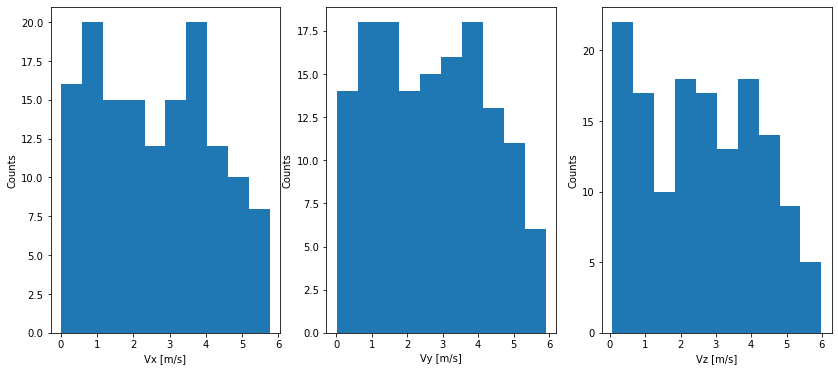

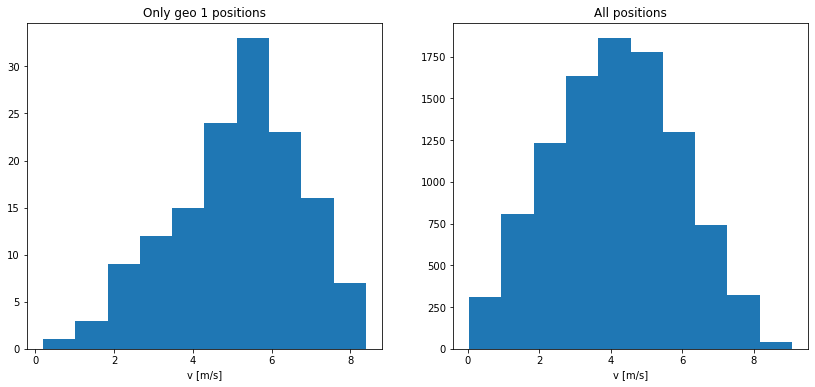

In [40]:
#all UCNs
particleSS_all = Nsnapshot.arrays(["vxend", "vyend", "vzend"])

#only ones in the #1 default geometry -> basically not in the He or the cell
particleSS_geo1 = Nsnapshot.arrays(["vxend", "vyend", "vzend"],  "solidend == 1")

Vx = np.abs(particleSS_geo1['vxend'])
Vy = np.abs(particleSS_geo1['vyend'])
Vz = np.abs(particleSS_geo1['vzend'])

V_mag_1 = np.sqrt(particleSS_geo1['vxend']**2 + particleSS_geo1['vyend']**2 + particleSS_geo1['vyend']**2)
V_mag_all = np.sqrt(particleSS_all['vxend']**2 + particleSS_all['vyend']**2 + particleSS_all['vyend']**2)

fig, axs = plt.subplots(1, 3, figsize=(14,6))

axs[0].hist(Vx)
axs[0].set_xlabel('Vx [m/s]')
axs[0].set_ylabel('Counts')

axs[1].hist(Vy)
axs[1].set_xlabel('Vy [m/s]')
axs[1].set_ylabel('Counts')

axs[2].hist(Vz)
axs[2].set_xlabel('Vz [m/s]')
axs[2].set_ylabel('Counts')

plt.show()

# total magnitude of velocity
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].hist(V_mag_1)
axs[0].set_title("Only geo 1 positions")
axs[0].set_xlabel("v [m/s]")
axs[1].hist(V_mag_all)
axs[1].set_title("All positions")
axs[1].set_xlabel("v [m/s]")

plt.show()

## Looking at energy

299792458.0


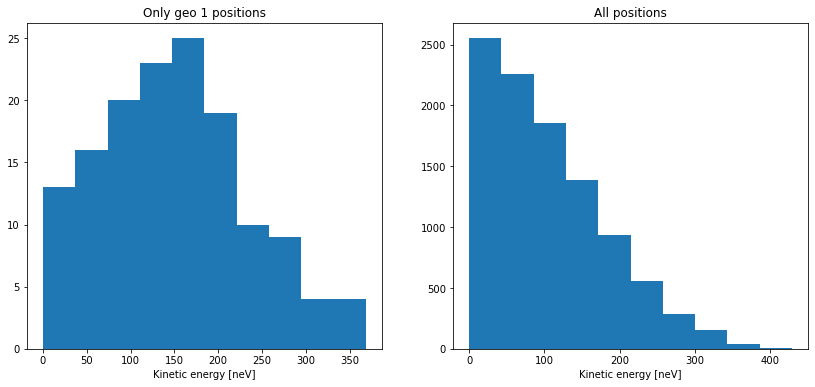

In [41]:
m_c = const.physical_constants["neutron mass energy equivalent in MeV"][0] * 1e6 #in eV
c = const.c #m/s

#converts non rel particle speed to kinetic energy
E_K = lambda v, mc2: 1/2 *mc2*(v/c)**2

#first looking at the resulting kinetic energy from the velocity that pentrack saves

fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].hist(E_K(V_mag_1, m_c)*1e9)
axs[0].set_title("Only geo 1 positions")
axs[0].set_xlabel("Kinetic energy [neV]")

axs[1].hist(E_K(V_mag_all, m_c)*1e9)
axs[1].set_title("All positions")
axs[1].set_xlabel("Kinetic energy [neV]")

plt.show()

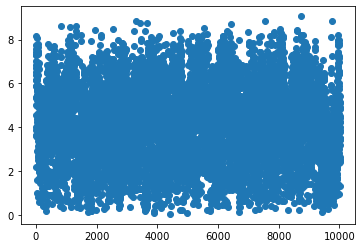

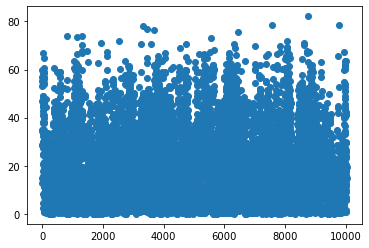

In [48]:
x = np.linspace(0, len(V_mag_all), len(V_mag_all))

plt.scatter(x, V_mag_all)
plt.show()

plt.scatter(x, V_mag_all**2)
plt.show()

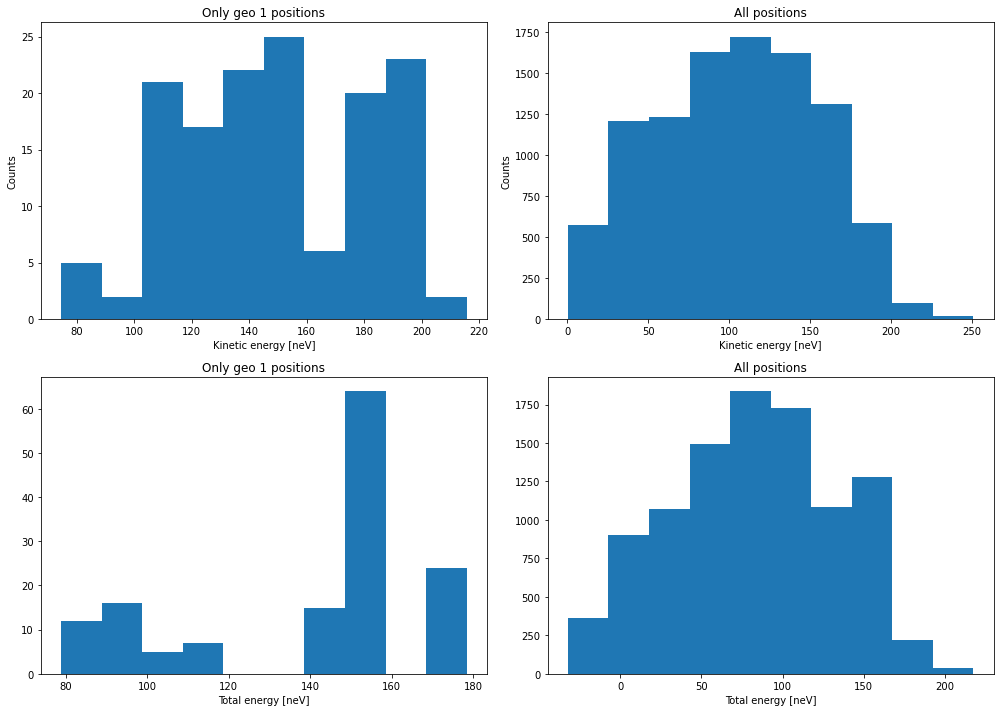

In [36]:
"""
Hend: final total energy of particle [eV]
Eend: final kinetic energy of the particle [eV]

Here we look at the actually energy that PENTrack saves, cause this is really much easier.
However these look quite different which is weird, how is PENTrack actually calculating 
the energy?
"""

#all UCNs
particleSS_all_E = Nsnapshot.arrays(["Eend", "Hend"])

#only ones in the #1 default geometry -> basically not in the He or the cell
particleSS_geo1_E = Nsnapshot.arrays(["Eend", "Hend"],  "solidend == 1")

fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()

axs[0].hist(particleSS_geo1_E["Eend"]*1e9)
axs[0].set_xlabel('Kinetic energy [neV]')
axs[0].set_ylabel('Counts')
axs[0].set_title("Only geo 1 positions")

axs[1].hist(particleSS_all_E["Eend"]*1e9)
axs[1].set_xlabel('Kinetic energy [neV]')
axs[1].set_ylabel('Counts')
axs[1].set_title("All positions")

# total magnitude of velocity
axs[2].hist(particleSS_geo1_E["Hend"]*1e9)
axs[2].set_title("Only geo 1 positions")
axs[2].set_xlabel("Total energy [neV]")

axs[3].hist(particleSS_all_E["Hend"]*1e9)
axs[3].set_title("All positions")
axs[3].set_xlabel("Total energy [neV]")

plt.tight_layout()

plt.show()

# Trying to get Neutrons only in certain geometries

In [4]:
'''
A function to graph the 3D positions of the UCNs, in a 3D scatter plot, with coloring of points
as a function of the geometry they are in, and also the option to label each point with
the timing [s].
'''
def plot3D_geoColor(x, y, z, geo, t=None, startPlot=True, endPlot=True, label="", \
                    figVals=None, ls="None", text_times=False, size=(8,8)):
    if startPlot:
        fig = plt.figure(figsize=size)
        ax1 = fig.add_subplot(1,1,1, projection='3d')
        ax1.set_xlim3d(-5, 7)
        ax1.set_ylim3d(-2, 0)
        ax1.set_zlim3d(-0.6, 0.5)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('z')
        
    else:
        #unpack the array that holds all the fig axes
        fig, ax1 = figVals
        
    point_features = np.transpose([getColor(g) for g in geo] )
    colors = point_features[0]
    geo_label = point_features[1]
    
    #for connections between points
    ax1.plot3D(x, y, z, linestyle=ls, marker='') 
    #for different colors of each point
    ax1.scatter(x, y, z, c=colors)
    
    #gets the labeling for each geometry color included
    for i, c in enumerate(colors):
        ax1.plot3D(100, 100, 100, linestyle="", marker='o', c=c, label=geo_label[i])
    
    if text_times:
        for i in range(len(x)): #plot each point's time as text above
            ax1.text(x[i],y[i],z[i],  '%s' % (str(t[i])), size=15, zorder=1, color='k') 
    
    if endPlot:
        ax1.legend()
        plt.show()
    else:
        #if it's not the end of the graph, return the figure objects
        return [fig, ax1]
    
def getColor(geo1):
    color = 'black'
    lab = None

    if geo1 == 183:
        #Long Y guide
        color = 'red'
        lab = 'Y_guide'
    elif geo1 in [187, 188]:
        #guides into chambers
        color = 'red'
    elif (2 <= geo1 <= 33) | (37 <= geo1 <= 114):
        #He vapour and liquid volumes 
        color='blue'
        lab = 'He'
    elif geo1 in [185, 186]:
        #in the chambers to do the rest of the experiment
        color = 'black'
        lab = 'in cell'
    elif geo1 == 1:
        #the default volume geometry
        color = 'orange'
        lab = '1'
        
    else: 
        print(geo1)
        
    return color, lab


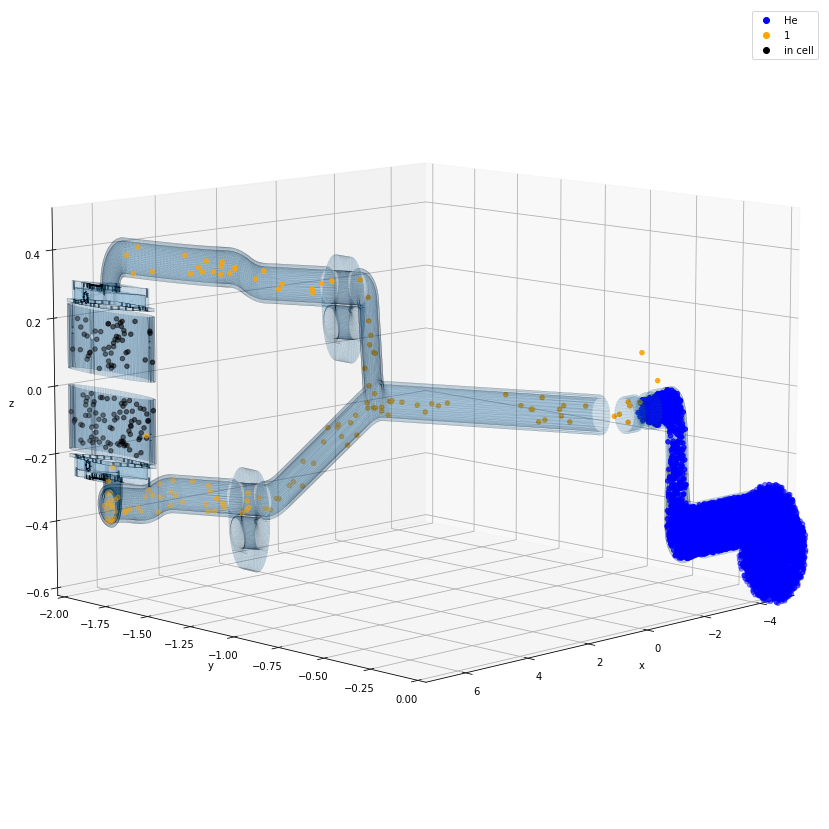

In [5]:
%matplotlib inline 
#lets you move the graph around within jupyter lab

#look at just one particle at different times
t = 100 #(tend%10==0) &
p = 5
# endSpots = Nsnapshot.arrays(["tend", "xend", "yend", "zend", 'solidend'], "(particle=={})".format(p), library="np")

#or all of them
endSpots = Nsnapshot.arrays(["tend", "xend", "yend", "zend", 'solidend', 'particle'], library="np")

x = endSpots['xend'].astype(float)
y = endSpots['yend'].astype(float)
z = endSpots['zend'].astype(float)
times = endSpots['tend'].astype(float)
geo_tag = endSpots['solidend'].astype(float)
   
figVals = plot3D_geoColor(x, y, z, geo_tag, times, label="All", startPlot=True, ls="", endPlot=False, size=(15,15))
fig, axis = figVals

axis.view_init(elev=10., azim=45)

#loads all the file I have in this folder as STLs
STLpath = 'STLsToGraph'
stl_array = os.listdir(STLpath)

for STLfile in stl_array:
    ppf.graphSTL(STLpath+'/'+STLfile, axis)
    
#removes repeated legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axis.legend(by_label.values(), by_label.keys())

# axis.legend()
plt.show()